In [1]:
from basebot import BaseBot
import yfinance as yf
from datetime import date
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
bot = BaseBot("testbot")
data = bot.getData("MSFT", date(2015,1,1), date.today(), technical_indicators = ["all"])
data["adj_close_pct_change"] = data["adj_close"].pct_change() # get daily returns
# make signal -1 or 1 depending on if the adj_close will be higher or lower in 7 days
data["signal"] = data["adj_close"].shift(-7) > data["adj_close"]
data["signal"] = data["signal"].astype(int)
# data["signal"] = data["signal"].replace(0, -1)
data["signal"] = data["signal"].fillna(1) # positive market outlook

data["signal"].value_counts()

1    882
0    638
Name: signal, dtype: int64

In [25]:
X, Y = data.drop(["ticker", "signal"], axis=1), data["signal"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
x_train_shuffled, _, y_train_shuffled, _ = train_test_split(X, Y, test_size=0.1, shuffle=True)

In [26]:
from xgboost import XGBClassifier
model = XGBClassifier(n_jobs = -1)
model.fit(x_train_shuffled, y_train_shuffled)
scr = model.score(x_train, y_train)
print("score of train: ", scr)
scr = model.score(x_test, y_test)
print("score of test: ", scr)

score of train:  0.9893092105263158
score of test:  0.9736842105263158


### simulate: grab best lookback based on train data

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

startMoney = 10000
bestWin = -9999999
bestSettings = dict()

for lookback in tqdm([1,5,7,10,13,15,20]):
    money = startMoney
    stocks = 0
    portfolio = []
    baseline = []
    baselineHowmany = money / x_train.iloc[0]["adj_close"]
    for i in range(lookback, len(x_train)):
        crntPrice = x_train.iloc[i]["adj_close"]
        preds = model.predict(x_train.iloc[i-lookback:i])
        # print("preds: ", preds)
        pred = np.median(preds)
        if pred == 1 and money > 10 and stocks == 0:
            # buy
            howMany = money / crntPrice * 0.98
            cost = howMany * crntPrice
            money -= cost
            stocks = howMany
        elif pred == 0 and stocks > 0:
            # sell
            money += stocks * crntPrice
            stocks = 0
        portfolio.append(money + stocks * crntPrice)
        baseline.append(baselineHowmany * crntPrice)
    if portfolio[-1] > bestWin:
        bestWin = portfolio[-1]
        bestSettings = dict(lookback = lookback, win=portfolio[-1], baselineWin = baselineHowmany, portfolio = portfolio, baseline = baseline)
print("best win: ", bestWin, lookback)

100%|██████████| 7/7 [00:37<00:00,  5.40s/it]

best win:  287374.7046618494 20


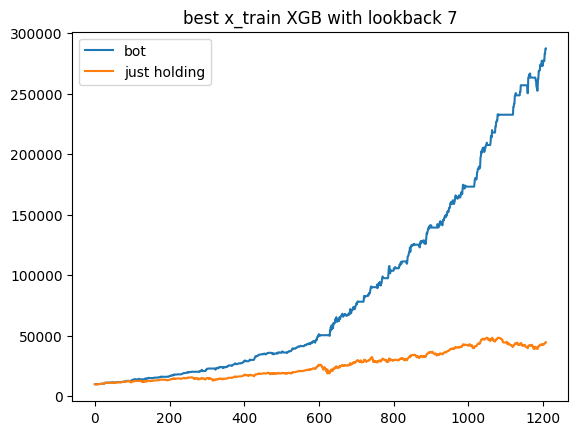

In [30]:
# just holding vs portfolio:
plt.plot(bestSettings["portfolio"], label = "bot")
plt.plot(bestSettings["baseline"], label = "just holding")
plt.title(f"best x_train XGB with lookback {bestSettings['lookback']}")
plt.legend()


### simulate: finally simulate with x_test and the best lookback we got from earlier

In [32]:
money = startMoney
stocks = 0
portfolio = []
baseline = []
baselineHowmany = money / x_test.iloc[0]["adj_close"]

lookback = bestSettings["lookback"]

for i in range(lookback, len(x_test)):
    crntPrice = x_test.iloc[i]["adj_close"]
    preds = model.predict(x_test.iloc[i-lookback:i])
    # print("preds: ", preds)
    pred = np.median(preds)
    if pred == 1 and money > 10 and stocks == 0:
        # buy
        howMany = money / crntPrice * 0.98
        cost = howMany * crntPrice
        money -= cost
        stocks = howMany
    elif pred == 0 and stocks > 0:
        # sell
        money += stocks * crntPrice
        stocks = 0
    portfolio.append(money + stocks * crntPrice)
    baseline.append(baselineHowmany * crntPrice)

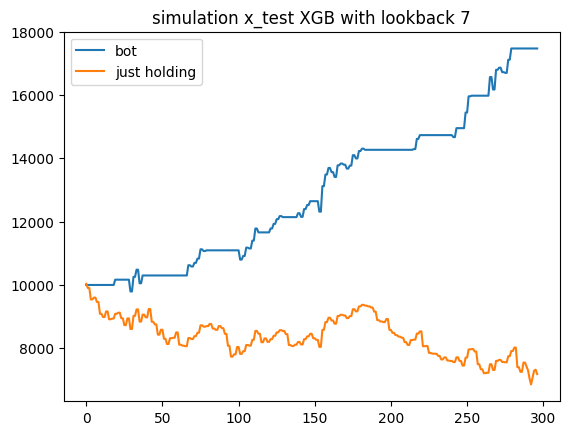

In [34]:
# just holding vs portfolio:
plt.plot(portfolio, label = "bot")
plt.plot(baseline, label = "just holding")
plt.title(f"simulation x_test XGB with lookback {lookback}")
plt.legend()


that is too good! there must be some error! but let's try to skim the model down